In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def generate_func(Nmax, a0, x):
    """ generates initial functions, made of Fourier modes as well as some discontinuities """

    # set up the Fourier modes
    N = np.random.randint(0, Nmax+1)
    n = np.arange(1, N+1).reshape((N,1))
    an = np.random.uniform(-1, 1, size=(N,1)) / n
    bn = np.random.uniform(-1, 1, size=(N,1)) / n

    # Fourier functions
    y = a0/2 + 0.5 * np.sum(an*np.cos(n*x) + bn*np.sin(n*x), axis=0)

    # sep up the discontinuities
    max_disc = 3
    M = np.random.randint(0, max_disc)
    c = 0.5 * np.random.uniform(-1, 1, size=(M))
    xd = np.random.uniform(0, 2*np.pi, size=(M))

    # add the discontinuities to the initial conditions
    for m in range(M):
        y *= np.piecewise(x, [x<xd[m], x>=xd[m]],
                         [lambda x: c[m]/np.pi*(x-xd[m]) + (1+c[m]),
                          lambda x: c[m]/np.pi*(x-xd[m]) + (1-c[m])])

    # return the initial solutions
    return y

def Init_W(gamma, x, test_case):
    """ computes the initial conditions """

    if test_case == "Sod":

        # Sod test case
        Density  = 1 * ( x < 0.5 ) + 0.125 * ( x >= 0.5 )
        Velocity = 0 * x
        Pressure = 1 * ( x < 0.5 ) + 0.1 * ( x >= 0.5 )
        Momentum = Density * Velocity
        Energy   = Pressure / (gamma - 1) + 0.5 * Density * Velocity**2

    elif test_case == "random":

        # Mach number and Fourier modes
        Mach = 10**np.random.uniform(np.log10(0.0001), np.log10(1000))
        Nmax = 8

        # Density
        a0 = 2
        Density = generate_func(Nmax, a0, x)
        if np.min(Density) <= 0: 
            Density += -np.min(Density) + 1e-2

        # Velocity (rescaled with the Mach number)
        a0 = np.random.uniform(-1,1)
        Velocity = generate_func(Nmax, a0, x)
        Velocity *= min(Mach, 1.0)

        # Pressure (rescaled with the Mach number)
        a0 = 2
        Temperature = generate_func(Nmax, a0, x)
        s1 = np.random.uniform(0.1, 1)
        Pressure = Density * Temperature * s1 * min(1.0 / Mach, 1.0)
        if np.min(Pressure) <= 0: 
            Pressure += -np.min(Pressure) + 1e-2

        # Momentum and Energy 
        Momentum = Density * Velocity
        Energy = Pressure / (gamma - 1.0) + 0.5 * Density * Velocity * Velocity

    return Density, Momentum, Energy

In [21]:
def get_Density(W):
    """ unpacks the vector W to get the Density """

    if len(np.shape(W)) == 1:
        return W[0]
    elif len(np.shape(W)) == 2:
        return W[:,0]

def unpack_W(W):
    """ unpacks the vector W to get Density, Momentum and Energy """

    if len(np.shape(W)) == 1:
        Density, Momentum, Energy = W
    elif len(np.shape(W)) == 2:
        Density = W[:,0]
        Momentum = W[:,1]
        Energy = W[:,2]

    return Density, Momentum, Energy

def compute_Velocity(W):
    """ computes the Velocity from the conserved variables W """

    Density, Momentum, Energy = unpack_W(W)
    return Momentum / Density

def compute_Sound_Speed( gamma, W ):
    """ computes the Sound Speed from the conserved variables W """

    return np.sqrt( gamma * compute_Pressure( gamma, W ) / get_Density(W) )

def compute_Pressure( gamma, W ):
    """ computes the Pressure from the conserved variables W """

    Density, Momentum, Energy = unpack_W(W)
    Velocity = Momentum / Density

    return ( gamma - 1 ) * ( Energy - 1/2 * Density * Velocity**2 )

def compute_Flux( gamma, W ):
    """ computes the physical Flux from the conserved variables W """

    Density, Momentum, Energy = unpack_W(W)

    Velocity = Momentum / Density
    Pressure = compute_Pressure( gamma, W )

    Flux_Density = Momentum
    Flux_Momentum = Density * Velocity**2 + Pressure
    Flux_Energy = Velocity * ( Energy + Pressure )

    return np.array([ Flux_Density, Flux_Momentum, Flux_Energy ]).T

In [22]:
def compute_Boundary_Conditions( W, BC_type = "periodic" ):
    """ computes the boundary conditions (periodic or Neumann), returns an array containing W and the two ghost cells """

    W_BC = np.zeros(( np.shape(W)[0] + 2, np.shape(W)[1] ))
    
    if BC_type == "periodic":
        W_BC[0] = W[-1]
        W_BC[-1] = W[0]
    elif BC_type == "Neumann":
        W_BC[0] = W[0]
        W_BC[-1] = W[-1]
    else:
        raise ValueError(" the boundary conditions {0} are not defined ".format(BC_type) )

    W_BC[1:-1] = W[:]

    return W_BC

In [23]:
def minmod(a, b):
    """ minmod limiter """

    limiter = np.zeros(np.shape(a))

    c1 = np.logical_and(a > 0, b > 0)
    limiter[c1] = np.minimum(a[c1], b[c1])

    c2 = np.logical_and(a < 0, b < 0)
    limiter[c2] = np.maximum(a[c2], b[c2])

    return limiter

def SST_viscous(a, b):
    """ order 3 limiter without smoothness detection [ Schmidtmann Seibold Torrilhon 2015 ] """

    zeros_N = np.zeros(np.shape(a))
    limiter = np.copy(zeros_N)

    positive_a = a > 0
    positive_b = b > 0

    c1 = np.logical_and(positive_a, positive_b)
    limiter[c1] = np.maximum(zeros_N[c1], np.minimum(np.minimum(2 * a[c1], 3 / 2 * b[c1]), (a[c1] + 2 * b[c1]) / 3))

    c2 = np.logical_and(np.logical_not(positive_a), positive_b)
    limiter[c2] = np.maximum(zeros_N[c2], np.minimum(- a[c2], (a[c2] + 2 * b[c2]) / 3))

    c3 = np.logical_and(positive_a, np.logical_not(positive_b))
    limiter[c3] = np.minimum(zeros_N[c3], np.maximum(- a[c3], (a[c3] + 2 * b[c3]) / 3))

    c4 = np.logical_and(np.logical_not(positive_a), np.logical_not(positive_b))
    limiter[c4] = np.minimum(zeros_N[c4], np.maximum(np.maximum(2 * a[c4], 3 / 2 * b[c4]), (a[c4] + 2 * b[c4]) / 3))

    return limiter

def HLL_Wave_Speeds( gamma, W_L, W_R ):
    """ computes the HLL Wave Speeds """

    Velocity_L = compute_Velocity(W_L)
    Velocity_R = compute_Velocity(W_R)

    Sound_L = compute_Sound_Speed( gamma, W_L )
    Sound_R = compute_Sound_Speed( gamma, W_R )

    return ( np.minimum( Velocity_L - Sound_L, Velocity_R - Sound_R ), 
             np.maximum( Velocity_L + Sound_L, Velocity_R + Sound_R ) )

def HLL_Flux( gamma, Lambda_L, Lambda_R, W_L, W_R ):
    """ computes the HLL numerical Flux """

    F_L, F_R = compute_Flux( gamma, W_L ).T, compute_Flux( gamma, W_R ).T

    numerical_Flux = ( F_L * ( Lambda_L >= 0 ) 
                     + F_R * ( Lambda_R <= 0 ) 
                     + ( Lambda_R * F_L - Lambda_L * F_R + Lambda_L * Lambda_R * ( W_R - W_L ).T ) / ( Lambda_R - Lambda_L )
                       * np.logical_and( Lambda_L < 0, Lambda_R > 0 ) )

    return numerical_Flux.T

def HLLC_Wave_Speeds( gamma, W_L, W_R ):
    """ computes the HLLC Wave Speeds """

    Density_L, Momentum_L, Energy_L = unpack_W(W_L)
    Density_R, Momentum_R, Energy_R = unpack_W(W_R)

    Velocity_L = compute_Velocity( W_L )
    Velocity_R = compute_Velocity( W_R )

    Pressure_L = compute_Pressure( gamma, W_L )
    Pressure_R = compute_Pressure( gamma, W_R )

    Sound_L = compute_Sound_Speed( gamma, W_L )
    Sound_R = compute_Sound_Speed( gamma, W_R )

    Pressure_Mean = ( Pressure_L + Pressure_R ) / 2
    Density_Mean = ( Density_L + Density_R ) / 2
    Sound_Mean = ( Sound_L + Sound_R ) / 2

    Pressure_Star = np.maximum( np.zeros_like(Pressure_Mean),
                                Pressure_Mean - Density_Mean * Sound_Mean * ( Velocity_R - Velocity_L ) / 2 )

    q_L = np.ones_like(Pressure_Star)
    condition_L = Pressure_Star > Pressure_L
    q_L[condition_L] = np.sqrt( 1 + (gamma + 1) / (2* gamma) * ( Pressure_Star[condition_L] / Pressure_L[condition_L] - 1 ) )

    q_R = np.ones_like(Pressure_Star)
    condition_R = Pressure_Star > Pressure_R
    q_R[condition_R] = np.sqrt( 1 + (gamma + 1) / (2* gamma) * ( Pressure_Star[condition_R] / Pressure_R[condition_R] - 1 ) )

    return ( Velocity_L - Sound_L * q_L, 
             Velocity_R + Sound_R * q_R )

def HLLC_Flux( gamma, Lambda_L, Lambda_R, W_L, W_R ):
    """ computes the HLLC numerical Flux """

    Density_L, Momentum_L, Energy_L = unpack_W(W_L)
    Density_R, Momentum_R, Energy_R = unpack_W(W_R)

    Velocity_L = compute_Velocity( W_L )
    Velocity_R = compute_Velocity( W_R )

    Pressure_L = compute_Pressure( gamma, W_L )
    Pressure_R = compute_Pressure( gamma, W_R )

    Lambda_Star = ( ( Pressure_R - Pressure_L
                    + Momentum_L * ( Lambda_L - Velocity_L )
                    - Momentum_R * ( Lambda_R - Velocity_R ) )
                  / ( Density_L * ( Lambda_L - Velocity_L )
                    - Density_R * ( Lambda_R - Velocity_R ) ) )

    Pressure_Star = Pressure_L + Density_L * ( Lambda_L - Velocity_L ) * ( Lambda_Star - Velocity_L )

    Density_L_Star = Density_L * ( Lambda_L - Velocity_L ) / ( Lambda_L - Lambda_Star )
    W_L_Star = np.array(( Density_L_Star,
                          Density_L_Star * Lambda_Star, 
                          Pressure_Star / (gamma - 1) + Density_L_Star * Lambda_Star**2 / 2 ))

    Density_R_Star = Density_R * ( Lambda_R - Velocity_R ) / ( Lambda_R - Lambda_Star )
    W_R_Star = np.array(( Density_R_Star,
                          Density_R_Star * Lambda_Star, 
                          Pressure_Star / (gamma - 1) + Density_R_Star * Lambda_Star**2 / 2 ))

    F_L, F_R = compute_Flux( gamma, W_L ).T, compute_Flux( gamma, W_R ).T

    F_L_Star = F_L + Lambda_L * ( W_L_Star - W_L.T )
    F_R_Star = F_R + Lambda_R * ( W_R_Star - W_R.T )

    numerical_Flux = ( F_L * ( Lambda_L >= 0 )
                     + F_L_Star * np.logical_and( Lambda_Star >= 0, Lambda_L < 0 )
                     + F_R_Star * np.logical_and( Lambda_R >= 0, Lambda_Star < 0 )
                     + F_R * ( Lambda_R < 0 ) )

    return numerical_Flux.T

def time_step( time, CFL, dx, gamma, W, BC_type, order=1, solver="HLLC" ):
    """ computes a single time step of the scheme """

    if solver == "HLL":
        compute_Wave_Speeds = HLL_Wave_Speeds 
        compute_Flux = HLL_Flux
    elif solver == "HLLC":
        compute_Wave_Speeds = HLLC_Wave_Speeds 
        compute_Flux = HLLC_Flux

    W_prev = compute_Boundary_Conditions( W, BC_type )

    if order == 1:
        W_L = W_prev[:-1]
        W_R = W_prev[+1:]

    else:
        W_recon_L = np.empty(np.shape(W))
        W_recon_R = np.empty(np.shape(W))

        Slopes = W_prev[1:] - W_prev[:-1]

        if order == 2:
            limited_Slopes = minmod(Slopes[:-1], Slopes[1:])
            W_recon_L = W_prev[1:-1] - limited_Slopes / 2
            W_recon_R = W_prev[1:-1] + limited_Slopes / 2
        elif order == 3:
            limited_Slopes_L = SST_viscous(Slopes[1:], Slopes[:-1])
            W_recon_L = W_prev[1:-1] - limited_Slopes_L / 2
            limited_Slopes_R = SST_viscous(Slopes[:-1], Slopes[1:])
            W_recon_R = W_prev[1:-1] + limited_Slopes_R / 2

        W_recon_L = compute_Boundary_Conditions(W_recon_L, BC_type)
        W_recon_R = compute_Boundary_Conditions(W_recon_R, BC_type)

        W_L = W_recon_R[:-1]
        W_R = W_recon_L[+1:]

    Lambda_L, Lambda_R = compute_Wave_Speeds( gamma, W_L, W_R )
    Flux = compute_Flux( gamma, Lambda_L, Lambda_R, W_L, W_R )

    dt = CFL * dx / max( np.max( Lambda_L ), np.max( Lambda_R ) )
    
    return W - dt/dx * ( Flux[1:] - Flux[:-1] ), dt

def update( time, CFL, dx, gamma, W_0, BC_type, order=1, solver="HLLC" ):
    """ computes the solution at time t^{n+1} from the solution at time t^n """

    if order == 1:
        return time_step( time, CFL, dx, gamma, W_0, BC_type, order=order, solver=solver )
    elif order == 2:
        W_1, dt_1 = time_step( time, CFL, dx, gamma, W_0, BC_type, order=order, solver=solver )
        W_2, dt_2 = time_step( time, CFL, dx, gamma, W_1, BC_type, order=order, solver=solver )
        return ( W_0 + W_2 ) / 2, min( dt_1, dt_2 )
    elif order == 3:
        W_1, dt_1 = time_step( time, CFL, dx, gamma, W_0, BC_type, order=order, solver=solver )
        W_2, dt_2 = time_step( time, CFL, dx, gamma, W_1, BC_type, order=order, solver=solver )
        W_2 = ( 3 * W_0 + 1 * W_2 ) / 4
        W_3, dt_3 = time_step( time, CFL, dx, gamma, W_2, BC_type, order=order, solver=solver )
        return ( 1 * W_0 + 2 * W_3 ) / 3, min( dt_1, dt_2, dt_3 )

In [24]:
def project_to_coarse_grid(nx_coarse, nx_ratio, W):
    """ projects the fine solution to the coarse grid """

    # split the array W in "nx_coarse-1" chunks (of size ratio = nx // nx_coarse), and average each chunk
    return np.mean( np.array_split(W[nx_ratio//2:-nx_ratio//2], nx_coarse-1), axis=1)

def project_and_keep_points(points_to_save, nx_coarse, nx_ratio, W, offset = 0):
    """ projects the fine solution to a coarse grid and keep only "points_to_save - 2" values """

    # after the projection, slice the array into "points_to_save" chunks
    W_proj = project_to_coarse_grid(nx_coarse, nx_ratio, W)[ : : nx_coarse // points_to_save ]

    # return a slice of W_proj, offset by -1, 0 or 1 (to eventually get W[i-1], W[i] and W[i+1])
    return W_proj[ 1 + offset : points_to_save - 1 + offset ]

def project_and_keep_points_and_add_values(points_to_save, nx_coarse, nx_ratio, W):
    """ projects the fine solution to a coarse grid, keep only "points_to_save" values, and add u, p, gamma """

    # project to the coarse grid, and keep only "points_to_save - 2" values
    W_im1_proj = project_and_keep_points(points_to_save, nx_coarse, nx_ratio, W, offset = -1)
    W_i_proj   = project_and_keep_points(points_to_save, nx_coarse, nx_ratio, W, offset =  0)
    W_ip1_proj = project_and_keep_points(points_to_save, nx_coarse, nx_ratio, W, offset = +1)

    # create the arrays to be returned: add three columns for the Velocity, the Pressure, and gamma
    W_im1_proj_full = np.zeros(( np.shape(W_im1_proj) + np.array([0,3]) ))
    W_i_proj_full   = np.zeros(( np.shape(W_i_proj  ) + np.array([0,3]) ))
    W_ip1_proj_full = np.zeros(( np.shape(W_ip1_proj) + np.array([0,3]) ))

    # add the Velocity, the Pressure, and gamma
    for W_proj, W_proj_full in zip( [ W_im1_proj, W_i_proj, W_ip1_proj ], [ W_im1_proj_full, W_i_proj_full, W_ip1_proj_full ] ):
        W_proj_full[:,:3] = W_proj
        W_proj_full[:,3] = compute_Velocity(W_proj)
        W_proj_full[:,4] = compute_Pressure(gamma, W_proj)
        W_proj_full[:,5] = gamma

    return W_im1_proj_full, W_i_proj_full, W_im1_proj_full


In [25]:
# test_case = "random"
test_case = "Sod"

test_solvers = True
# test_solvers = False

generate_data = False
# generate_data = True

load_data = False
# load_data = True

xmin = 0
if test_case == "Sod":
    xmax = 1
elif test_case == "random":
    xmax = 2 * np.pi

# nx: number of points in the fine grid
nx = 75
dx = ( xmax - xmin ) / nx
x = np.arange( xmin, xmax, dx )

# nx_coarse: number of points in the coarse grid (must be an integer multiple of nx)
nx_coarse = nx
dx_coarse = ( xmax - xmin ) / nx_coarse
x_coarse = np.arange( xmin, xmax, dx_coarse )

nx_ratio = nx // nx_coarse
if nx_ratio * nx_coarse != nx:
    raise ValueError(" the ratio between nx = {0} and nx_coarse = {1} must be an integer ".format( nx, nx_coarse ))

# we will save coarse data each "save_data_each"th point in space and each "time_steps_to_save"th time step
save_data_each = 5
points_to_save = nx_coarse // save_data_each
time_steps_to_save = points_to_save // 2

CFL = 0.5
gamma = 1.4

# W is the solution on the fine grid
W = np.zeros(( nx, 3 ))

if test_case == "Sod":
    BC_type = "Neumann"
    end_time = 0.15
elif test_case == "random":
    BC_type = "periodic"
    end_time = 0.15
else:
    raise ValueError(" test case {0} not defined ".format(test_case) )

In [26]:
if generate_data:

    # we will run "n_simulations" simulations
    n_simulations = 50
    i_simulation = 0
    all_data = []

    print("saving data for {0} simulations, each one involving {1} time steps and {2} space points".format(
        n_simulations, time_steps_to_save, points_to_save - 2
    ))

    while i_simulation < n_simulations:

        # random initial condition
        W[:,0], W[:,1], W[:,2] = Init_W(gamma, x, test_case)

        time = 0
        time_iter = 0

        # the list "array_to_save" will be filled as the time loop advances
        array_to_save = []

        # we save "time_steps_to_save" time steps
        while (len(array_to_save) < time_steps_to_save ):

            # save solution every "2 * nx // points_to_save"-th time iteration
            if ( time_iter % ( 2 * nx // points_to_save ) == 0 ):

                # get the values of the projections of W[i-1], W[i] and W[i+1] at time t^n
                W_im1_n_proj, W_i_n_proj, W_ip1_n_proj = project_and_keep_points_and_add_values(points_to_save, nx_coarse, nx_ratio, W)

                # update W in time
                W, dt = update( time, CFL, dx, gamma, W, BC_type )

                # get the values of the projection of W[i] at time t^n
                W_i_np1_proj = project_and_keep_points(points_to_save, nx_coarse, nx_ratio, W)

                # compute the physical Flux F_i^n and the difference of numerical Fluxes ΔF = -Δx/Δt ( F_i^{n+1} - F_i^n )
                Physical_Flux_n = compute_Flux( gamma, W_i_n_proj[:,:3] )
                d_Numerical_Flux = - dx / dt * ( W_i_np1_proj - W_i_n_proj[:,:3] )

                # stack the fluxes to get a (points_to_save,6)-shaped array, like each W_im1_n_proj, W_i_n_proj, W_ip1_n_proj
                Fluxes = np.hstack(( Physical_Flux_n, d_Numerical_Flux ))

                # add the values to be saved to array_to_save
                array_to_save += [np.array([ W_im1_n_proj, W_i_n_proj, W_ip1_n_proj, Fluxes ])]

            # only update if the solution is not saved
            else:
                W, dt = update( time, CFL, dx, gamma, W, BC_type )
                
            time += dt
            time_iter += 1

        array_to_save = np.array(array_to_save)

        # check for nans in the final array
        nan_in_array = False
        for val in array_to_save.flat:
            if np.isnan(val):
                nan_in_array = True
                break

        # is more than one time iteration was performed and no nans are present in the array, add it to all the simulation data
        if ( time_iter > 1 ) and (not nan_in_array):
            i_simulation += 1
            all_data += [array_to_save]
            print("simulation #{0:3d} done".format(i_simulation))

    # save the simulation data to the file "filename"
    filename = "data.npy"
    np.save(filename, all_data)
    print("saved data of shape {0} to file {1}".format(np.shape(all_data), filename))

    # ### DATA FORMAT ###
    # all_data is a np.array of shape ( n_simulations, time_steps_to_save, 4, points_to_save, 6 )
    #   -> n_simulations        : Euler simulations with a randomized initial condition
    #   -> time_steps_to_save   : time steps to keep for each simulation
    #   -> points_to_save       : space points to keep for each simulation
    #   -> 4, 6                 : we save 4 vectors, each with 6 values
    #                             the first 3 vectors are W_{i-1}^n, W_i^n and W_{i+1}^n, each containing Density, Momentum, Energy, Velocity, Pressure, gamma
    #                             the last vector contains both F(W_i^n) (3 components) and - dx / dt * ( W_i^{n+1} - W_i^n ) (3 components)


In [27]:
if load_data:

    # load the simulation data from the file "filename"
    filename = "data.npy"
    all_data = np.load(filename)

    # get the number of simulations, time steps and space points from the data
    n_simulations = np.shape(all_data)[0]
    n_time_steps  = np.shape(all_data)[1]
    n_space_saves = np.shape(all_data)[3]

    print("loading data for {0} simulations, each one involving {1} time steps and {2} space points".format(
        n_simulations, n_time_steps, n_space_saves
    ))

    # create the arrays corresponding to the data to be recovered
    W_im1_n_proj = np.empty((n_simulations, n_time_steps, n_space_saves, 6))
    W_i_n_proj   = np.empty((n_simulations, n_time_steps, n_space_saves, 6))
    W_ip1_n_proj = np.empty((n_simulations, n_time_steps, n_space_saves, 6))
    Physical_Flux_n  = np.empty((n_simulations, n_time_steps, n_space_saves, 3))
    d_Numerical_Flux = np.empty((n_simulations, n_time_steps, n_space_saves, 3))

    # loop through "all_data" to recover the simulation data
    for i_simu, array_simu in enumerate(all_data):
        for i_time, val_time in enumerate(array_simu):
            W_im1_n_proj[i_simu, i_time], W_i_n_proj[i_simu, i_time], W_ip1_n_proj[i_simu, i_time], Fluxes = val_time
            Physical_Flux_n[i_simu, i_time] = Fluxes[:,:3]
            d_Numerical_Flux[i_simu, i_time] = Fluxes[:,3:]

    print("loading done")


<ipython-input-21-2e663cb780da>:30: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt( gamma * compute_Pressure( gamma, W ) / get_Density(W) )


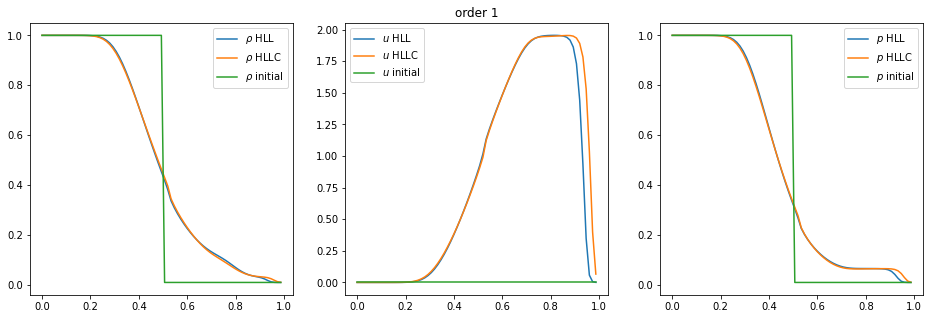

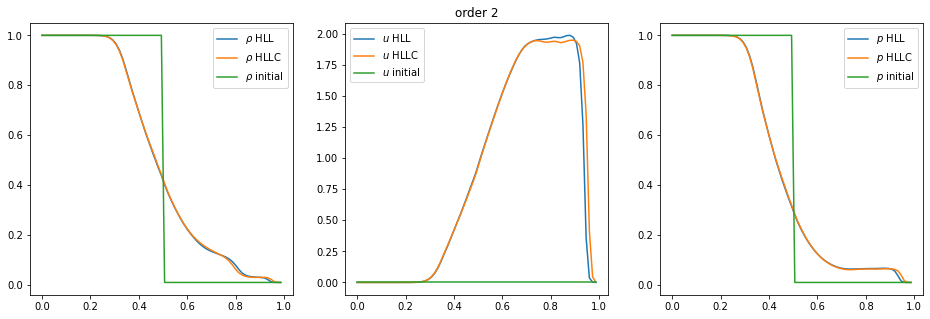

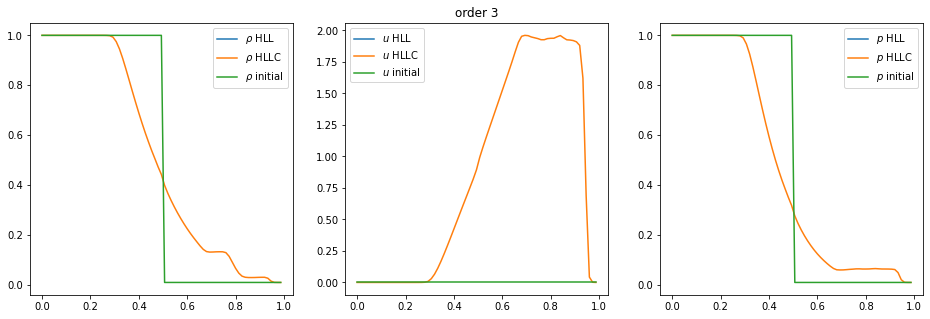

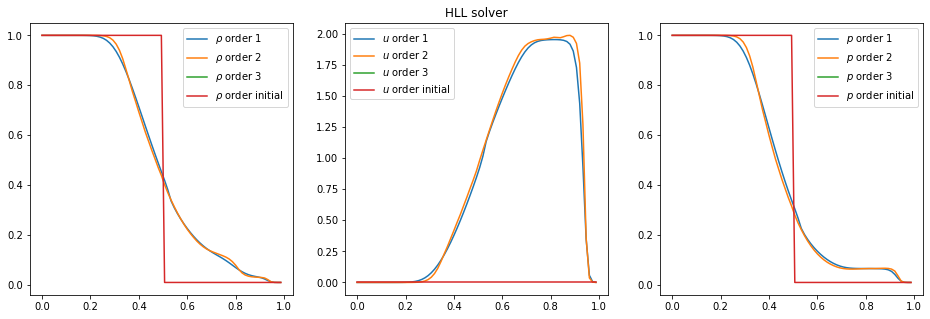

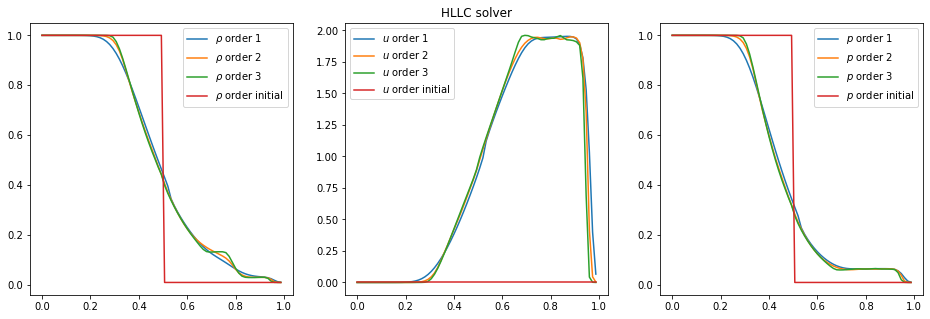

In [28]:
if test_solvers:

    W_ini = np.copy(W)
    W_ini[:, 0], W_ini[:, 1], W_ini[:, 2] = Init_W(gamma, x, test_case)

    all_W = np.empty(( 2, 3, *np.shape(W_ini) ))

    for i_order, order in enumerate([ 1, 2, 3 ]):
        for i_solver, solver in enumerate([ "HLL", "HLLC" ]):

            W = np.copy(W_ini)
            time = 0

            while time < end_time:
                W, dt = update( time, CFL, dx, gamma, W, BC_type, order=order, solver=solver )
                time += dt
            
            all_W[i_solver, i_order] = W

    for i_order, order in enumerate([ 1, 2, 3 ]):

        fig, ax = plt.subplots( 1, 3, figsize = (16,5) )
        ax[1].set_title(f"order {order}")

        for W_, legend in zip( [ all_W[0, i_order], all_W[1, i_order], W_ini ], [ "HLL", "HLLC", "initial" ] ):
            ax[0].plot( x, get_Density(W_), label = r"$\rho$ {0}".format(legend) );
            ax[1].plot( x, compute_Velocity(W_), label = r"$u$ {0}".format(legend) );
            ax[2].plot( x, compute_Pressure( gamma, W_ ), label = r"$p$ {0}".format(legend) );
            [ ax[i].legend() for i in range(len(ax)) ]

    for i_solver, solver in enumerate([ "HLL", "HLLC" ]):

        fig, ax = plt.subplots( 1, 3, figsize = (16,5) )
        ax[1].set_title(f"{solver} solver")

        for W_, legend in zip( [ *all_W[i_solver], W_ini ], [ "1", "2", "3", "initial" ] ):
            ax[0].plot( x, get_Density(W_), label = r"$\rho$ order {0}".format(legend) );
            ax[1].plot( x, compute_Velocity(W_), label = r"$u$ order {0}".format(legend) );
            ax[2].plot( x, compute_Pressure( gamma, W_ ), label = r"$p$ order {0}".format(legend) );
            [ ax[i].legend() for i in range(len(ax)) ]